In [1]:
import anndata
import pathlib
import sciviewer_control as ctl

data_dir = pathlib.Path("data")
adata = anndata.read_h5ad(data_dir / "sciviewer-virus.h5ad")

To keep this exercise simple, we will filter to only the 5000 most variable genes.

In [2]:
import numpy as np
import scanpy as sc

sc.pp.highly_variable_genes(adata, n_top_genes=5000)
adata = adata[:, adata.var.highly_variable]

Unlike traditional multiple testing methods, the results of an online test will depend on the order in which tests arrive. The block below orders genes so that those that are most similar appear near to one another. This is motivated by the observation that alpha investing "boosts statistical power in cases in which the nonnull hypotheses appear in batches" (Javanmard and Montanari, 2018).

In [3]:
from scipy.cluster.hierarchy import linkage, leaves_list

linkage_matrix = linkage(np.corrcoef(adata.X.T))
order = leaves_list(linkage_matrix)
adata = adata[:, order]

We first test association with the y-axis direction. The underlying projection scores are overlaid on the UMAP below.

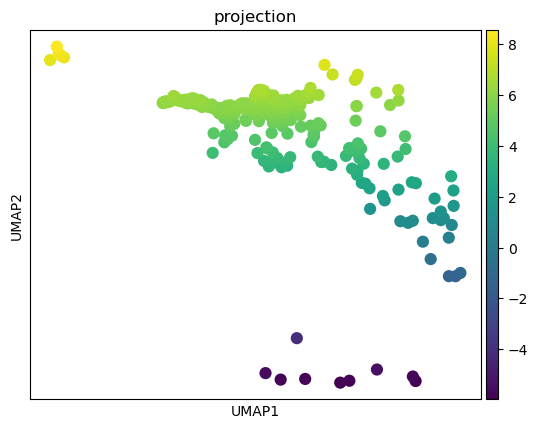

In [4]:
direction = np.array([0, 1])
adata.obs["projection"] = adata.obsm["X_umap"] @ direction
sc.pl.umap(adata, color='projection')

We get p-values for this direction using the same t-test calculation from `calculateGeneCorrelations` in [sciviewer.py](https://github.com/colabobio/sciviewer/blob/785e3c0e67eb55f68cb29b46848c528c383174e7/sciviewer/sciviewer.py#L557). We also initialize the online FDR results using `lord_test`, which is a direct translation of the `lord++` method from onlineFDR Bioconductor package (here's their [paper](https://doi.org/10.1093/bioinformatics/btz191)).

In [5]:
batch_result = ctl.test_direction(adata.X, adata.obs["projection"])
online_result_initial = ctl.lord_test(batch_result["p_value"], alpha=0.01)

These are the results for this direction. Higher points are more significant, orange points are selected in online testing.

In [6]:
import altair as alt
alt.data_transformers.enable("vegafusion")

ctl.plot_pval_sequence(online_result_initial, width=300)

alt.Chart(...)

Next, let's test the association with the x-axis direction. Now the projection score (color) varies as we go left to right.

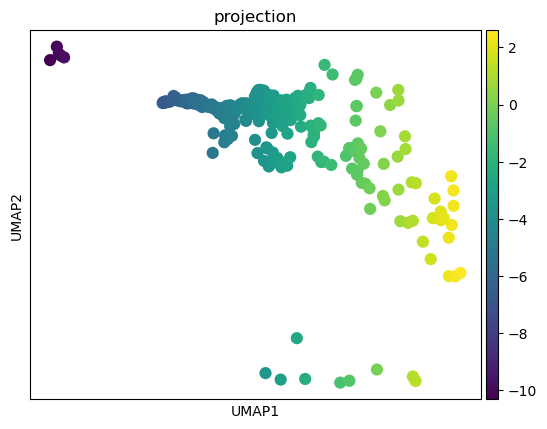

In [7]:
direction_new = np.array([1, 0])
adata.obs["projection"] = adata.obsm["X_umap"] @ direction_new
sc.pl.umap(adata, color='projection')

We test this new direction and update our online test results. The output `online_result_updated` now has 10K rows, since we have 5K genes and have tested two directions. Internally, we only calculate new thresholds for the newly introduced p-values.

In [8]:
batch_result_new = ctl.test_direction(adata.X, adata.obs["projection"])
p_values = np.concatenate([batch_result["p_value"], batch_result_new["p_value"]])
online_result_updated = ctl.lord_test(p_values, online_result_initial, alpha=0.01)

Here are the same p-values as before, but updated to include associations with the second direction. We can see that we make many more discoveries in this second direction (index starting after 5000). This makes sense, since in the UMAP the cells mainly seem to vary along the x-axis direction. We might expect real biological variation along that direction.

In [9]:
ctl.plot_pval_sequence(online_result_updated)

alt.Chart(...)

Under-the-hood, LORD++ is computing a sequence of significance thresholds. Every time a discovery is made, the threshold becomes more lenient. Every time we fail to reject a hypothesis, the threshold becomes more stringent. This explains the pattern of the thresholds below -- in the regions with the richest signal, we have the highest thresholds.

In [10]:
ctl.plot_alpha_sequence(online_result_updated)

alt.Chart(...)